In [1]:
import os
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from dataset import voc
from retinanet import model, val
from retinanet import transforms as aug
%matplotlib inline

In [2]:
# consts
tag = 'debug'
split_name = 'voc-1'
root_path = '/home/voyager/data/root/voc/'

device_name = 'cpu'
batch_size = 24
depth = 50
image_size = 512
max_detections = 4
num_classes = 2

if not os.path.exists('./result'):
    os.mkdir('./result')

# the path previous model saved
result_path = './result/{}_{}_{}_{}'.format(
    tag,
    depth,
    split_name,
    "20190516_175626"
)

model_name = "151_0.3333"

In [3]:
val_trans = aug.Compose([
    aug.Pad(),
    aug.Resize(image_size, image_size),
    aug.AutoLevel(min_level_rate=1, max_level_rate=1),
    aug.AutoContrast(),
    aug.Contrast(1.25),
    aug.ToTensor()
])

val_set = voc.VOCDetection(
    root_path,
    image_set="{}_val".format(split_name),
#     image_set="{}_train".format(split_name),
    transforms=val_trans
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=voc.collate
)
net = torch.load(os.path.join(result_path, model_name +".pth"))

/home/voyager/anaconda3/envs/pytorch_0.4.1/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'retinanet.model.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
def _get_detections(dataset, retinanet, nms=None, detection_scale=None, num_classes=2, score_threshold=0.5, max_detections=100, save_path=None, model_name=None):
    
    all_detections = [[None for i in range(num_classes)] for j in range(len(dataset))]
    retinanet.eval()
    
    # for optimize
    if nms:
        retinanet.set_nms(nms)
        
    with torch.no_grad():

        for index in range(len(dataset)):
            data = dataset[index]
            # data is a tuple: (img, ([labels], [gts], {scale, pad_loc...}))
            scale = data[1][2]["scale"]
            # get pad loc, up, down, left, right
            pad_loc = data[1][2]["pad_loc"]

            # run network
            scores, labels, boxes = retinanet(data[0].permute(0, 1, 2).cuda().float().unsqueeze(dim=0))
            scores = scores.cpu().numpy()
            labels = labels.cpu().numpy()
            boxes  = boxes.cpu().numpy()
            
            # for optimize
            if detection_scale:
                for bbx in boxes:
                    center_x = (bbx[0] + bbx[2]) / 2
                    center_y = (bbx[1] + bbx[3]) / 2
                    new_width = (bbx[2] - bbx[0]) * detection_scale
                    new_height = (bbx[3] - bbx[1]) * detection_scale
                    bbx[0] = center_x - ( new_width / 2 )
                    bbx[2] = center_x + ( new_width / 2 )
                    bbx[1] = center_y - ( new_height /2 )
                    bbx[3] = center_y + ( new_height /2 )
            
            # correct boxes for image scale, boxes最初是512大小，优化阶段并不需要图像成原图
#             boxes /= scale
# #             print(boxes.shape)
#             for bbx in boxes:
#                 # height fix
#                 bbx[1] -= pad_loc[0]
#                 bbx[3] -= pad_loc[0]
#                 # width fix
#                 bbx[0] -= pad_loc[2]
#                 bbx[2] -= pad_loc[2]
            

            # select indices which have a score above the threshold
            indices = np.where(scores > score_threshold)[0]
            if indices.shape[0] > 0:
                # select those scores
                scores = scores[indices]

                # find the order with which to sort the scores
                scores_sort = np.argsort(-scores)[:max_detections]

                # select detections
                image_boxes      = boxes[indices[scores_sort], :]
                image_scores     = scores[scores_sort]
                image_labels     = labels[indices[scores_sort]]
                image_detections = np.concatenate([image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)
                
                # copy detections to all_detections
                for label in range(num_classes):
                    all_detections[index][label] = image_detections[image_detections[:, -1] == label, :-1]
            else:
                # copy detections to all_detections
                for label in range(num_classes):
                    all_detections[index][label] = np.zeros((0, 5))
            
#             print("{}/{}".format(index + 1, len(dataset)), end='\r')
            print("\r {}/{}".format(index + 1, len(dataset)), end='')
    
    # save all_detections to a csv under save_path
    if save_path:
        csv_data = pd.DataFrame(columns=['id', 'serial', 'class', 'score', 'x1', 'y1', 'x2', 'y2', 'prob'])
        csv_id = 0
        for index in range(len(all_detections)):
            image_name = dataset.images[index].split('/')[-1].split('.')[0]
            for label in range(len(all_detections[index])):
                for box in range(len(all_detections[index][label])):
                    bbx = all_detections[index][label][box]
                    csv_data.loc[csv_id] = [image_name, box, label, 0, bbx[0], bbx[1], bbx[2], bbx[3], bbx[4]]
                    csv_id += 1
                    
        file_name = "{}_{}_{}_{}".format(
            model_name,
            num_classes,
            score_threshold,
            max_detections
        )
        if nms:
            file_name = file_name + "_" + str(nms)
        if detection_scale:
            file_name = file_name + "_" + str(detection_scale)
        
        print("\nsave to ", save_path, file_name + ".csv")
        csv_data.to_csv(os.path.join(save_path, file_name+".csv"))
    
    return all_detections

In [5]:
def _get_annotations(generator, num_classes):
    all_annotations = [[None for i in range(num_classes)] for j in range(len(generator))]
    
    for index in range(len(generator)):
        # load the annotations, annotations is a tuple: (img, ([labels], [gts], {scale, pad_loc...}))
        annotations = generator[index][1]
        labels = annotations[0].numpy()
        boxes = annotations[1].numpy()
        
        for label in range(num_classes):
            if label in labels:
                id_list = np.where(labels == label)[0]
                all_annotations[index][label] = boxes[id_list]
            else:
                all_annotations[index][label] = np.zeros((0, 5))

    return all_annotations

In [6]:
def _compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def compute_overlap(a, b):
    """
    Parameters
    ----------
    a: (N, 4) ndarray of float
    b: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua

In [7]:
def evaluate(generator, retinanet, nms=None, iou_threshold=0.5, detection_scale=None, num_classes=2, score_threshold=0.9, max_detections=4, save_path=None, model_name=None):
    # gather all detections and annotations
    all_detections     = _get_detections(generator, retinanet, nms=nms, detection_scale=detection_scale, num_classes=num_classes, score_threshold=score_threshold, max_detections=max_detections, save_path=save_path, model_name=model_name)
    all_annotations    = _get_annotations(generator, num_classes=num_classes)
#     print(all_annotations[0], all_detections[0])
    detect_amount = {}
    average_precisions = {}
    final_recall = {}
    final_precision = {}
    image_lists = {}
    
    for label in range(num_classes):
        false_positives = np.zeros((0,))
        true_positives  = np.zeros((0,))
        scores          = np.zeros((0,))
        num_annotations = 0.0
        num_detections = 0.0
        image_list = []
        
        # len(generator) == 317
        for i in range(len(generator)):
            detections           = all_detections[i][label]
            annotations          = all_annotations[i][label]
            num_annotations     += annotations.shape[0]
            detected_annotations = []
            
#             print(detections)
            # 很多label 0 并没有预测出来，所以导致recall = true_positives / num_annotations分母过大
            if detections.shape[0] > 0:
                num_detections += detections.shape[0]
            else:
                continue
                
            bad_flag = False
                        
            for d in detections:
                # detection[4] are scores 
                scores = np.append(scores, d[4])
                # 如果原图都没有框，则 fp + 1, tp + 0
                if annotations.shape[0] == 0:
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0)
                    continue
                
                # d 是预测的每一个box, overlaps是覆盖率的list
                overlaps            = compute_overlap(np.expand_dims(d, axis=0), annotations)
                # 覆盖率最大的坐标
                assigned_annotation = np.argmax(overlaps, axis=1)
                # 最大覆盖率
                max_overlap         = overlaps[0, assigned_annotation]
#                 print(max_overlap)

                if max_overlap < iou_threshold:
#                     print(i, max_overlap, "<", iou_threshold)
                    bad_flag = True
            
                # 如果覆盖率大于iou_threshold，则 tp + 1， fp + 0，否则反之
                # assigned_annotation not in detected_annotations 应该总是true
                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives = np.append(false_positives, 0)
                    true_positives  = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0)
            
            if bad_flag:
#                 image_list.append(generator.images[i].split('/')[-1].split('.')[0])
                image_list.append(i)
            
        # no annotations -> AP for this class is 0 (is this correct?)
        # 原数据，两个类别分别是 0：384， 1：358个框
        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue
        
        # sort by score
        indices         = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives  = true_positives[indices]
        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives  = np.cumsum(true_positives)

        # compute recall and precision，recall和precision是单调的曲线，从而积分计算ap
        recall    = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)
        
        # compute average precision
        average_precision  = _compute_ap(recall, precision)
        
        # 有预测的比例
        detect_amount[label] = num_detections
        average_precisions[label] = average_precision
        # 预测成功占anno
        final_recall[label] = recall[-1]
        # 预测成功占detection
        final_precision[label] = precision[-1]
        image_lists[label] = image_list
    
    return detect_amount, average_precisions, final_recall, final_precision, image_lists

初始化各项参数

In [8]:
generator = val_set
retinanet = net

# optimize initialize
iou_threshold = 0.3
score_threshold = 0.5
nms = 0.7 
detection_scale = 1

选择优化对象，score， nms， detection_scale的最好选择区间已经标出。并准备好储存结果的数据结构。

基于数次实验，有以下结论：
1. score取值[0.5, 0.6]
2. nms 取值[0.65, 0.7]
3. detection_scale 取值并无太大关系
4. iou取值 [0.2, 0.3] 取值并无太大关系

In [9]:
score_threshold_list = [ x / 100 for x in range(50, 60) if x % 5 == 0]
nms_list = [ x / 100 for x in range(60, 100) if x % 5 == 0]
detection_scale_list = [ x / 100 for x in range(70, 100) if x % 5 == 0]
iou_threshold_list = [ x / 10 for x in range(1, 4)]

optimize_object_list = score_threshold_list
# prepare dataframe for result 
label_zero = pd.DataFrame(np.arange(len(optimize_object_list) * 4).reshape((len(optimize_object_list),4)), index=optimize_object_list,columns=['detect_amount','average_precisions','recall','precision']) 
label_one  = label_zero.copy()
image_lists = {0:{}, 1:{}}

optimize_object_list

[0.5, 0.55]

In [10]:
for optimize_object in optimize_object_list:
    print(optimize_object)
    result = evaluate(val_set, 
              net, 
              # replace the target variable you want optimize
              nms=nms,
              score_threshold=score_threshold,
              detection_scale=detection_scale,
              iou_threshold=optimize_object, 
              ###############################################
              num_classes=num_classes, 
              max_detections=max_detections, 
              save_path=result_path,
              model_name=model_name
             )
    # result[index][label], but infact we dont care label 1
    label_zero.loc[optimize_object] = [result[0][0], result[1][0], result[2][0], result[3][0]]
    # label_one.loc[optimize_object] = [result[0][1], result[1][1], result[2][1], result[3][1]]
    image_lists[0][optimize_object] = result[4][0]
    # image_lists[1][optimize_object] = result[4][1]

0.5
 3/317

/home/voyager/anaconda3/envs/pytorch_0.4.1/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


 317/317
save to  ./result/debug_50_voc-1_20190516_175626 151_0.3333_2_0.5_4_0.7_1.csv
0.55
 317/317
save to  ./result/debug_50_voc-1_20190516_175626 151_0.3333_2_0.5_4_0.7_1.csv


In [11]:
label_zero

,detect_amount,average_precisions,recall,precision
0.50,378.0,0.876058,0.888021,0.902116
0.55,378.0,0.846455,0.867188,0.880952


In [12]:
image_lists[0]

{0.5: [34,
  43,
  51,
  72,
  86,
  91,
  94,
  134,
  148,
  158,
  182,
  201,
  202,
  213,
  224,
  273,
  282,
  302,
  307,
  311],
 0.55: [27,
  34,
  43,
  51,
  54,
  72,
  82,
  86,
  91,
  94,
  134,
  148,
  158,
  161,
  162,
  180,
  182,
  201,
  202,
  213,
  214,
  224,
  273,
  282,
  301,
  302,
  307,
  311]}

作画函数

In [13]:
# draw boxes on images 
def draw_both_box(data_set, img_pd, image_list, img_path=None, origin_color=[0, 0, 255], detection_color=[0, 255, 0]):
    # img_list is [id1, id2...], draw origin box following data_set, draw detection following img_pd
    for image_id in image_list:
        # get np_img
        image_name = data_set.images[image_id].split('/')[-1].split('.')[0]
        # img = Image.open(os.path.join(img_path, image_name + ".jpg"))
        # np_img = np.asarray(img)
        np_img = data_set[image_id][0].numpy()
        np_img = np.transpose(np_img, (1, 2, 0))
        # draw origin box
        anno = data_set[image_id][1]
        classes = anno[0].numpy()
        gts = anno[1].numpy()
        
        # get class 0, 副作用：算覆盖率的时候筛出来的错误框可能并不显示在图像上
        gts = gts[np.where(classes == 0)[0]]
        
        bbs = []
        for gt in gts:
            bbs.append(BoundingBox(x1=gt[0], y1=gt[1], x2=gt[2], y2=gt[3]))

        bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
        draw_img = bbs_on_img.draw_on_image(np_img, size=2, color=origin_color)
        
        # draw detection box
        img_some = img_pd[img_pd['id'] == image_name]
        # get class 0
        img_some = img_some[img_some['class'] == 0]
        
        for index in range(img_some.shape[0]):
            img_detect = img_some.iloc[index]
        
            img_id = img_detect['id']
            label = img_detect['class']
            x1 = img_detect['x1']
            y1 = img_detect['y1']
            x2 = img_detect['x2']
            y2 = img_detect['y2']
            bbs = []
            bbs.append(BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2))
            bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
            draw_img = bbs_on_img.draw_on_image(draw_img, size=2, color=detection_color)
            
            d = np.array([x1, y1, x2, y2, img_detect['prob']])

            overlaps            = compute_overlap(np.expand_dims(d, axis=0), gts)
            assigned_annotation = np.argmax(overlaps, axis=1)
            max_overlap         = overlaps[0, assigned_annotation]
            print(max_overlap)
        
        ia.imshow(draw_img)

### 对比原标注和预测标注

注意读取的csv的名字问题，因为之前不同的预测结果储存到了不同的csv中。记住将优化对象赋值给此处变量即可。

In [14]:
score_threshold = 0.5
nms = 0.7 
detection_scale = 1
detection = "{}_{}_{}_{}_{}_{}.csv".format(
            model_name,
            num_classes,
            score_threshold,
            max_detections,
            nms,
            detection_scale
        )
img_pd = pd.read_csv(os.path.join("./result/debug_50_voc-1_20190516_175626", detection), index_col=0)
img_path = "/home/voyager/data/root/voc/JPEGImages"

下面将画出在对比中表现差的图像，即false_positive，或者是表现好的图像，true_positive。

In [16]:
false_positive = image_lists[0][score_threshold]
true_positive = []
for i in range(len(val_set.images)):
    if i not in image_lists[0][score_threshold]:
        true_positive.append(i)

image_list = false_positive

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.7708526]
[0.]


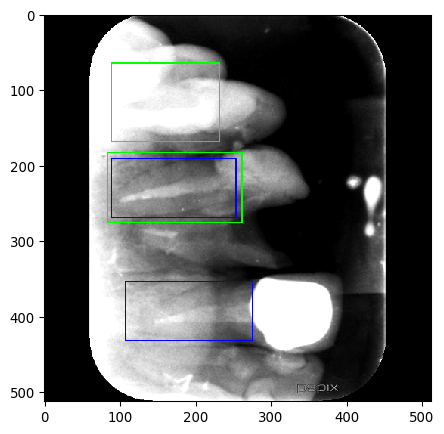

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.43300422]


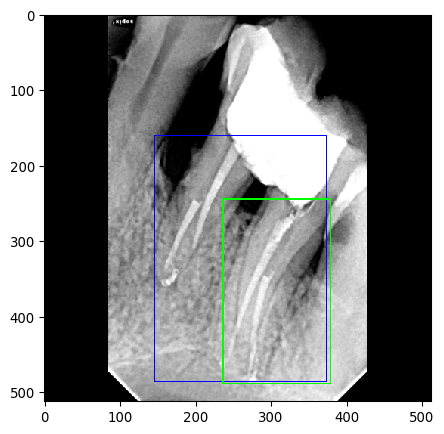

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]
[0.71865092]


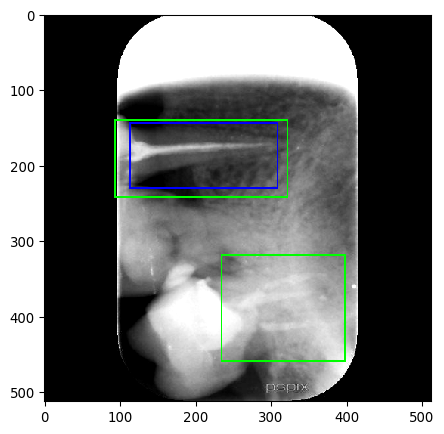

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.4464174]
[0.61223362]
[0.43823998]


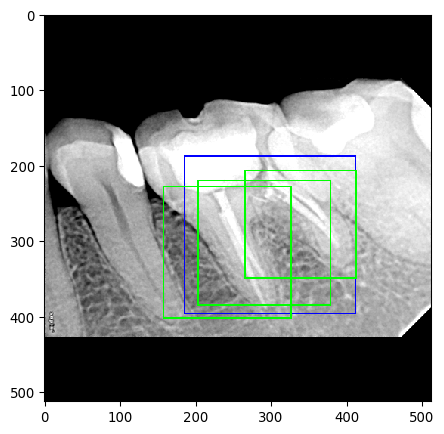

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.76221323]
[0.]


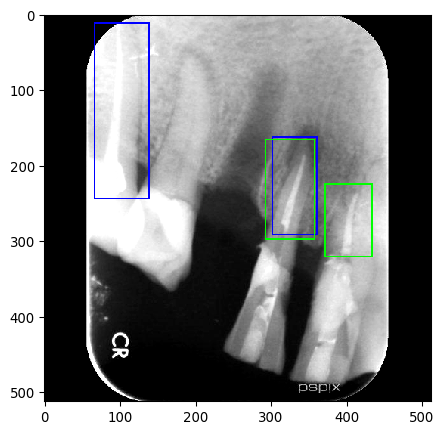

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]
[0.37829934]


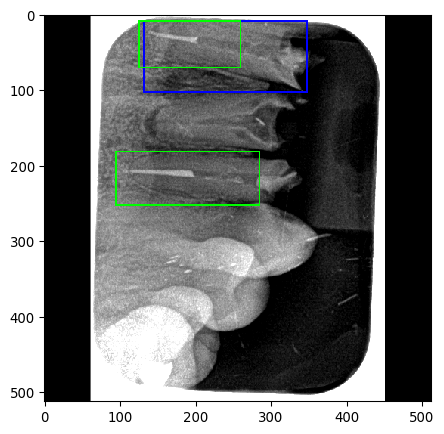

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.46444887]


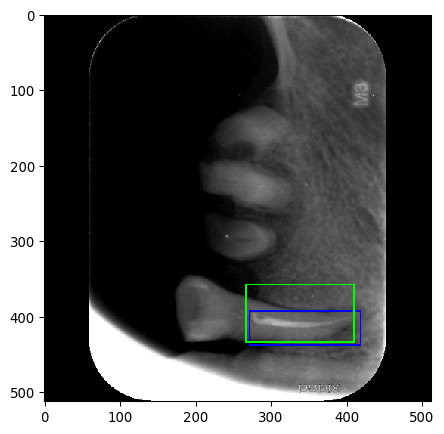

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.86086597]
[0.41686821]


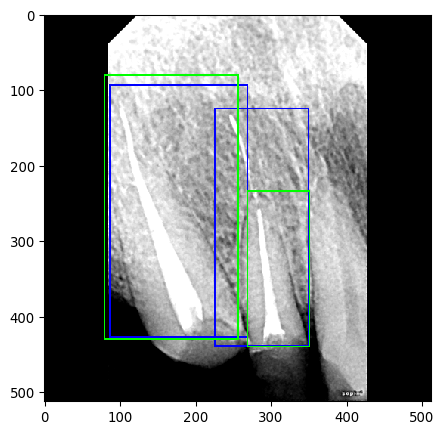

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.68021775]
[0.]


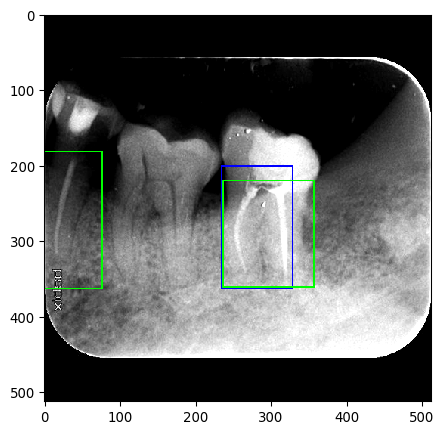

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.83013174]
[0.]
[0.]


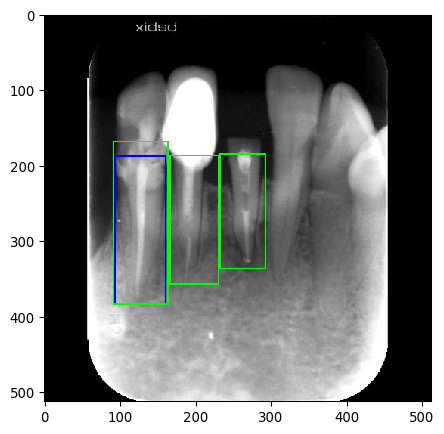

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.42233178]
[0.73791895]


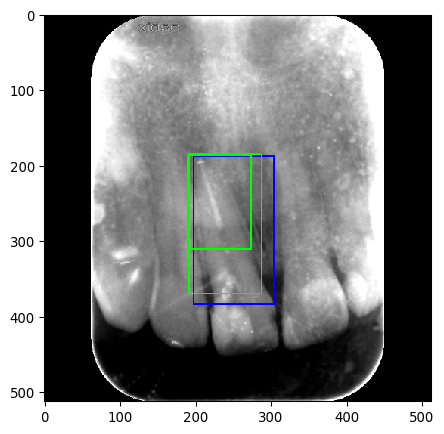

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.7475404]
[0.]


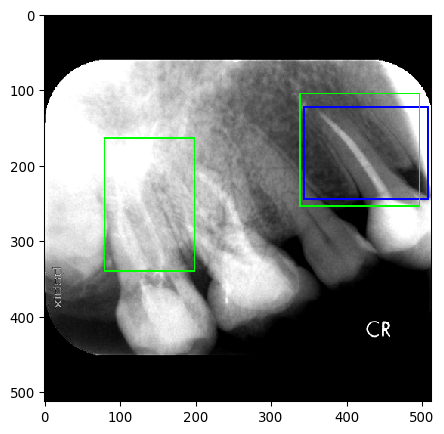

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]


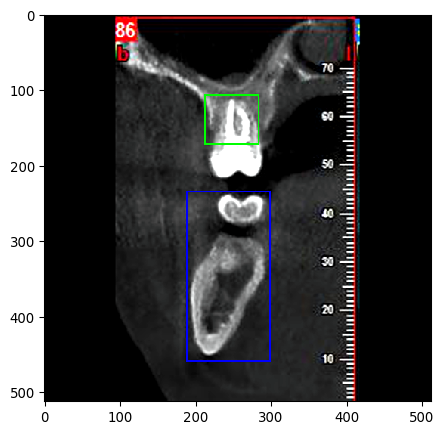

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.54510316]
[0.3841269]
[0.]


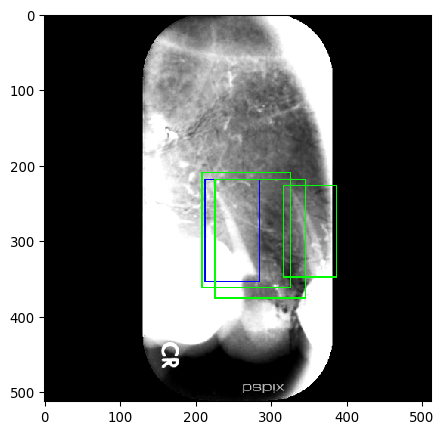

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.63789289]
[0.]


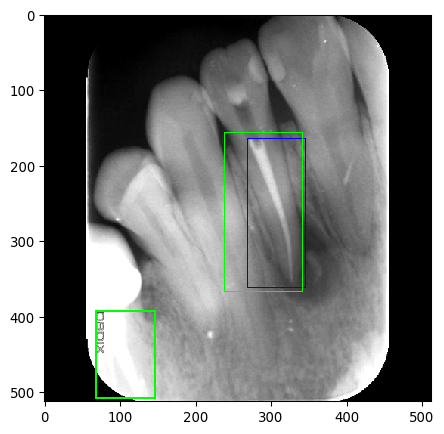

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.86210763]
[0.]


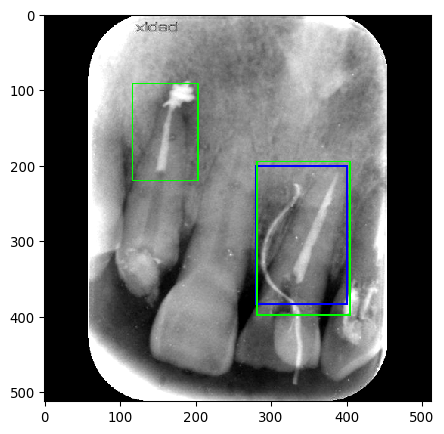

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.86498581]
[0.87634551]
[0.]


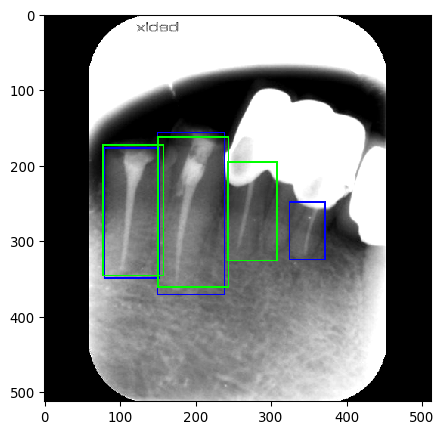

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.75879317]
[0.]
[0.]


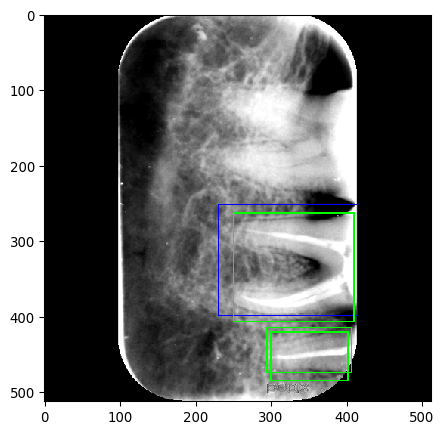

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.87319049]
[0.]


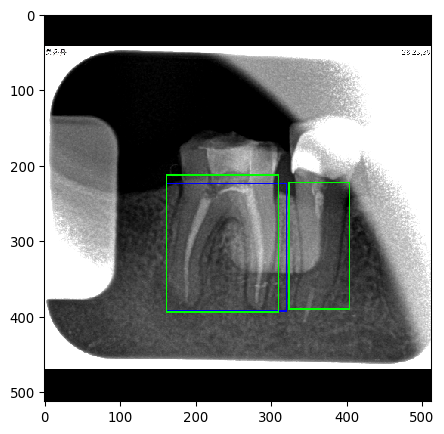

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.38253763]
[0.59425954]


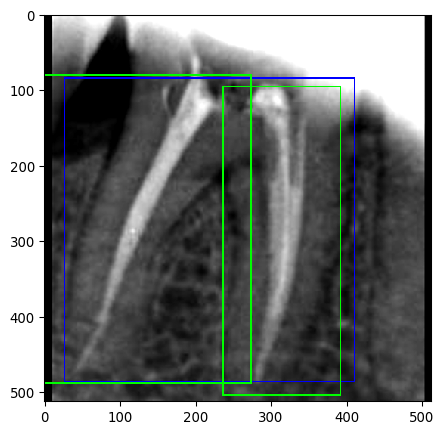

In [17]:
draw_both_box(val_set, img_pd, image_list=image_list, img_path=img_path)